In [1]:
from emulator import *
import pyccl as ccl

In [2]:
emulator = AemulusNu_HMF_Emulator()

#Plank 2018
cosmology = {'10^9 As':2.09681,
            'ns': 0.9652,
            'H0': 67.37,
            'w0': -1,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'nu_mass_ev': 0.07071068,
            'sigma8': 0.8101,
            }
h = cosmology['H0']/100
Ωb =  cosmology['ombh2'] / h**2
Ωc =  cosmology['omch2'] / h**2

cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

In [3]:
M = 10**np.linspace(13, 17, 100)
z = np.linspace(0, 1, 25)

In [4]:
# Create meshgrid
M_grid, z_grid = np.meshgrid(M, z)

In [5]:
from scipy.interpolate import RectBivariateSpline

In [6]:
# Evaluate the function over the grid
# Replace this loop with the actual evaluation of your function
dndm_evaluated = np.zeros_like(M_grid)
for i in trange(len(z)):
    for j in range(len(M)):
        dndm_evaluated[i, j] = emulator.predict_dndm(cosmology, z[i], M[j])

  0%|          | 0/25 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:43: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res, err = quad(lambda k: dσ2dk(k, R, pk), 0, 20/R, limit=1000)
/home/users/delon/aemulusnu_massfunction/utils.py:59: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res, err = quad(lambda k: dσ2dRdk(k, R, pk), 0, 20/R, limit=1000)
100%|██████████| 25/25 [03:56<00:00,  9.44s/it]


In [61]:
emulator.predict_params(cosmology, 0)

{'d': 0.538585001620815,
 'e': 1.1947285146903583,
 'f': 2.334544729461631,
 'g': 1.280766378337934}

In [62]:
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%('Box_n50_0_1400', 1), "rb") as f:
    prev_params_final = pickle.load(f)
    print(prev_params_final)


{'d': 0.5386276198712852, 'e': 1.2000023112345803, 'f': 2.3350250729717823, 'g': 1.2824601068447752}


In [7]:
# Fit the spline
log_dndm = RectBivariateSpline(z, M, np.log(dndm_evaluated))
dndm = lambda z, m: np.exp(log_dndm(z,m ))

In [93]:
[1e14, 1e15] * dndm(1, [1e14, 1e15])[0]

array([1.41242218e-05, 5.96117766e-08])

/tmp/ipykernel_8387/2285464621.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('rainbow')
/tmp/ipykernel_8387/2285464621.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z value')


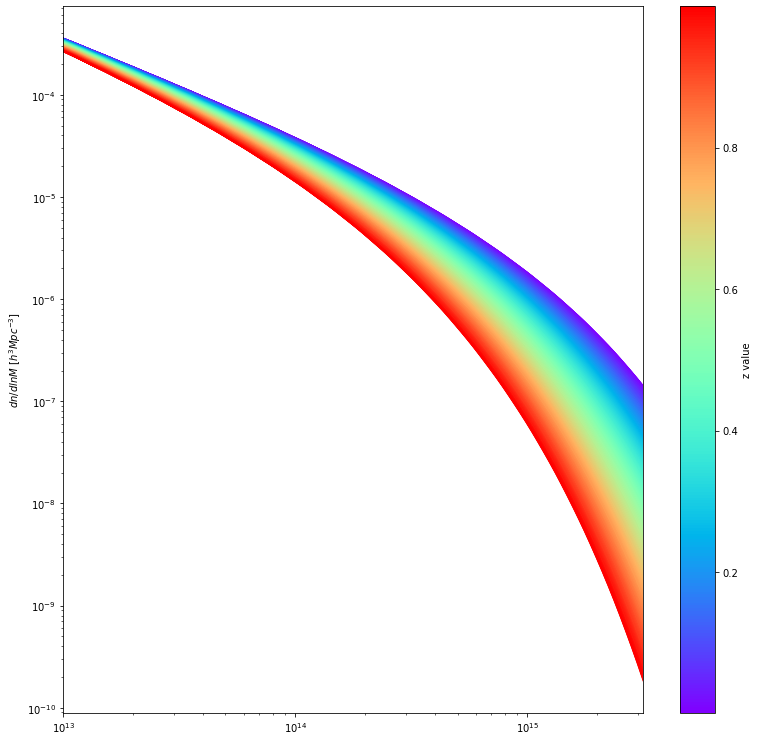

In [94]:
from matplotlib import cm
from matplotlib.cm import ScalarMappable
plt.figure(figsize=(13,13))

znum = np.random.uniform(0, 1, size=1000)
znum = sorted(znum)
# Assuming z is already defined and dndm is your function
M_values = 10**np.linspace(13, 15.5, 100)

# Define a colormap and normalize the z values
norm = plt.Normalize(min(znum), max(znum))
colormap = cm.get_cmap('rainbow')

# Plot each line with color according to z_curr
for z_curr in znum:
    color = colormap(norm(z_curr))
    plt.plot(M_values, M_values*dndm(z_curr, M_values)[0], color=color)

plt.xscale('log')
plt.yscale('log')

plt.ylabel(r'$dn/dln M\ [h^3 Mpc^{-3}]$')
# Add a colorbar to show the correspondence between colors and z values
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='z value')
plt.xlim(10**13, 10**15.5)
plt.show()

In [9]:
import matplotlib.pyplot as plt

# Generate test points (you can choose other methods for generating these)
M_test = 10**np.random.uniform(13, 17, size=50)
z_test = np.random.choice(z, size=10)

# Evaluate the spline at the test points
print('spline predictions')
spline_predictions = [dndm(z_val, M_val).item() for z_val in z_test for M_val in M_test]

# Evaluate the actual function at the test points
print('emulator predictions')
actual_values = [emulator.predict_dndm(cosmology, z_val, M_val) for z_val in z_test for M_val in M_test]

# Compute the fractional error
print('fractional errors')
fractional_errors = [(pred - actual) / actual for pred, actual in zip(spline_predictions, actual_values)]


spline predictions
emulator predictions
fractional errors


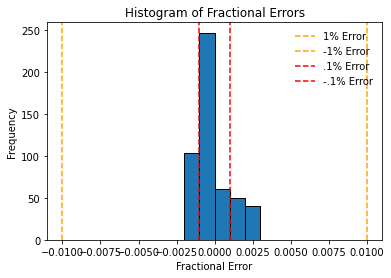

In [10]:
# Plot a histogram of the fractional errors
plt.hist(fractional_errors, bins=20, range=(-0.01, 0.01), edgecolor='black')
plt.axvline(x=0.01, color='orange', linestyle='--', label='1% Error')
plt.axvline(x=-0.01, color='orange', linestyle='--', label='-1% Error')

plt.axvline(x=0.001, color='r', linestyle='--', label='.1% Error')
plt.axvline(x=-0.001, color='r', linestyle='--', label='-.1% Error')

plt.xlabel('Fractional Error')
plt.ylabel('Frequency')
plt.title('Histogram of Fractional Errors')
plt.legend(frameon=False)


In [102]:

    
def cluster_richness_relation(M, λ, z):
    
    #equation (10) to To, Krause+20
    #reading valaues from figure B1, TODO get actual ML values
    Aλ = .9
    lnλ0 = 3.8
    Bλ = -0.4
    Mpiv = 5e14 # h^-1 M_sol
    lnλMean = lnλ0 + Aλ* np.log(M/Mpiv) + Bλ*np.log((1+z)/1.45)

    σintrinsic = 0.3
    σlnλ = np.sqrt(σintrinsic) #im simplifying eq(9) of To, Krause+20, it seems like second term is small? 
    
    
    norm = 1/(np.sqrt(2*np.pi) * λ * σlnλ)
    arg = (np.log(λ) - lnλMean)**2 
    arg /= 2 * σlnλ ** 2
    return norm * np.exp(-arg)

In [36]:
lnMbar(20, 0)

32.413498728238444

In [37]:
np.log(1e14)

32.23619130191664

In [12]:
M = 10**np.linspace(13, 17, 100)
z = np.linspace(0, 1, 25)
λ = np.linspace(10, 100, 250)

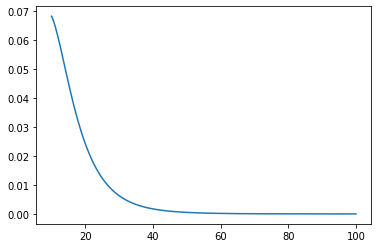

In [103]:
plt.plot(λ, [cluster_richness_relation(10**14, λc, 0) for λc in λ])

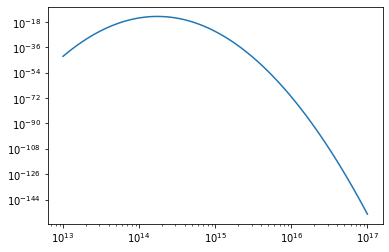

In [14]:
plt.plot(M, [cluster_richness_relation(m, 30, 0) for m in M])
plt.xscale('log')
plt.yscale('log')

In [15]:
# Evaluate the function on the grid
cluster_richess_evaluated = np.zeros((len(M), len(λ), len(z)))
for i, m in enumerate(M):
    for j, lam in enumerate(λ):
        for k, z_val in enumerate(z):
            cluster_richess_evaluated[i, j, k] = cluster_richness_relation(m, lam, z_val)

In [104]:
Ωs = 18000 # deg^2
Ωs_rad = 5/9 * np.pi**2 # rad^2

From http://background.uchicago.edu/~whu/courses/Ast448/dist_ref.pdf the comoving volume element
$$\frac{dV}{d\Omega dz} = D_H \frac{(1+z)^2 D_A^2}{E(z)}$$
Where
- $D_A$ is angular diameter disitance
- $D_H$ is the hubble distance
- $E(z)=\sqrt{\Omega_M(1+z)^3 + \Omega_k(1+z)^2 + \Omega_\Lambda}$

In [17]:
print(Ωb, Ωc)

0.049198926683442175 0.2639512501870297


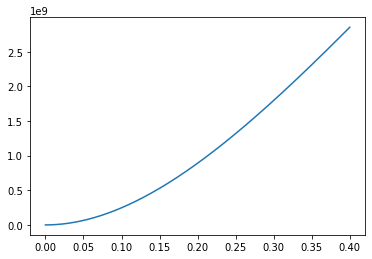

In [105]:
def comoving_volume_elements(z):
    DA = ccl.angular_diameter_distance(cosmo, 1/(1+z)) * h # Mpc / h 
    #According to ccl_background.h, this uses dΩ [radians]
    Ez = np.sqrt((Ωb+Ωc)*(1+z)**3 + (1-(Ωb+Ωc))) # unitless
    DH = 3000 #[h^{-1} Mpc] 
    return DH*(1+z)**2*DA**2/Ez # h^{-3} Mpc^3 already has units volume? what are angular units??

znum = np.linspace(0.0,0.4,1000)
plt.plot(znum, comoving_volume_elements(znum))

In [108]:
from scipy.integrate import dblquad


def integrand(M, z_val):
    dn_dM = dndm(z_val, M) # h^4 / (Mpc^3  Msun)
    d2V_dzdOmega = comoving_volume_elements(z_val) # Mpc^3 / h^3
    return dn_dM * d2V_dzdOmega # h / (Msun)
            #[dz dM ] = Msun / h ===> 1 / rad^2

# Parameters
M_min = 1e12
M_max = 10**17
z_min = 0.4       
z_max = 0.6      

# Compute the integral
result, error = dblquad(integrand, z_min, z_max, M_min, M_max, epsabs=1e-20)
print("Result of the integral: %.1e"%(Ωs_rad*result))
print("Estimated error:", Ωs_rad*error)
print( error / result )

Result of the integral: 2.6e+06
Estimated error: 0.22033816160733743
8.596060264024594e-08


In [109]:
from scipy.integrate import tplquad

def integrand(lam, M, z_val):
    p = cluster_richness_relation(M, lam, z_val) # h / Msun
    dn_dM = dndm(z_val, M) # h^4 / (Mpc^3  Msun)
    d2V_dzdOmega = comoving_volume_elements(z_val) # Mpc^3 / h^3
    return p * dn_dM * d2V_dzdOmega # h / (Msun)
            #[dz dM ] = Msun / h ===> 1 / rad^2

def lambda_bounds(M, z_val):
    return lambda_min, lambda_max

def M_bounds(z_val):
    return M_min, M_max

def z_bounds():
    return z_min, z_max

# Parameters
M_min = 1e12
M_max = 10**17
lambda_min = 20
lambda_max = 40
z_min = 0.4       
z_max = 0.6      

# Compute the integral
result, error = tplquad(integrand, z_min, z_max, M_min, M_max, lambda_min, lambda_max, epsabs=1e-20)
print("Result of the integral: %.1e"%(Ωs_rad*result))
print("Estimated error:", Ωs_rad*error)
print( error / result )

Result of the integral: 2.6e+04
Estimated error: 0.0019499093606332447
7.392744975694441e-08


In [69]:
from scipy.integrate import quad

def integrand(M):
    dn_dM = dndm(0, M) # h^4 / (Mpc^3  Msun)
    return  dn_dM  


result, error = quad(integrand, 10**(14.1), 10**(14.2), epsabs=1e-20)
print("Result of the integral: %.1e"%(1050**3 * result))
print("Estimated error:", error)
print( error / result )

Result of the integral: 7.0e+03
Estimated error: 7.379357578935878e-16
1.2274391672575392e-10


In [20]:
from scipy.integrate import quad

def integrand(M):
    lam = 30
    z_val = 0
    p = cluster_richness_relation(M, lam, z_val)
    return p 

# Compute the integral
result, error = quad(integrand, 1e-5, 1e18, epsabs=1e-20)
print("Result of the integral:", result)
print("Estimated error:", error)
print( error / result )

Result of the integral: 1.0000000000000002
Estimated error: 2.870469624667455e-13
2.8704696246674545e-13


In [48]:
def volume_integrand(z_val):
    return comoving_volume_elements(z_val) # Mpc^3 / h^3
# Compute the integral
result, error = quad(volume_integrand, 0, 2, epsabs=1e-20)
print("Result of the integral: %.1e"%(Ωs_rad * result)) # Mpc^3 / h^3
print("Estimated error:", Ωs_rad * error)
print( error / result )

Result of the integral: 8.5e+10
Estimated error: 81.12902736656117
9.540436841060993e-10


In [21]:
from scipy.integrate import quad
def lognorm(x):
    norm = 1/(np.sqrt(2*np.pi)*x*3)
    arg = (-12+np.log(x))**2
    arg /= 18
    return norm*np.exp(-arg)
def integrand(x):
    p = lognorm(x)
    return p 

# Compute the integral
result, error = quad(integrand, 1e-10, 1000000000, epsabs=1e-20)
print("Result of the integral:", result)
print("Estimated error:", error)
print( error / result )

Result of the integral: 0.9981798345861901
Estimated error: 9.642115328389878e-09
9.659697575825258e-09
